In [104]:
import astra
import niftiutils.helper_fxns as hf
import os
import shutil
import pandas as pd
import numpy as np
import pylab

import dicom2nifti
import dicom2nifti.compressed_dicom as compressed_dicom
%matplotlib inline

In [512]:
img_dir = r"D:\CBCT\Aaron"
dcm_path = img_dir+"\\15814.dcm"

In [513]:
dicom_input = compressed_dicom.read_file(dcm_path,
                                           defer_size=100,
                                           stop_before_pixels=False,
                                           force=False)

In [ ]:
dicom_input

In [514]:
cine_rate = float(dicom_input[('0018', '0040')].value)
kvp = float(dicom_input[('0018', '0060')].value)
d_detector = int(dicom_input[('0018', '1110')].value)
d_patient = int(dicom_input[('0018', '1111')].value)
t_exposure = int(dicom_input[('0018', '1150')].value)
current = int(dicom_input[('0018', '1151')].value)
exposure = int(dicom_input[('0018', '1152')].value)
pixel_spacing = dicom_input[('0018', '1164')].value
angle1 = float(dicom_input[('0018', '1510')].value)
angle2 = float(dicom_input[('0018', '1511')].value)
angle1_increment = dicom_input[('0018', '1520')].value
angle2_increment = dicom_input[('0018', '1521')].value
shutter_edges = [int(dicom_input[('0018', str(x))].value) for x in [1602, 1604, 1606, 1608]]

In [137]:
with open("angles.txt", 'w') as f:
    for a in angle1_increment:
        f.write(str(angle1+a)+"\n")

In [480]:
imgs = dicom_input[('7fe0', '0010')].value

In [515]:
rows = dicom_input[('0028', '0010')].value
cols = dicom_input[('0028', '0011')].value
ch = dicom_input[('0028', '0002')].value
frames = int(dicom_input[('0028', '0008')].value)

In [485]:
ls = list(dicom_input[('7fe0', '0010')].value)
img = [ls[x]+ls[x+1]*256 for x in range(0,len(ls),2)]
img = np.reshape(img,(frames,rows,cols))
canon_img = np.transpose(img, (2,1,0))[:,::-1,:]

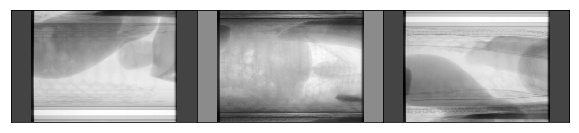

In [359]:
hf.draw_slices(canon_img,width=10)

In [487]:
recon_img = np.transpose(img, (1,0,2))[::-1,:,:]
recon_img.shape

(297, 384, 384)

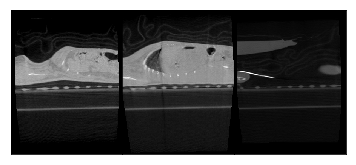

In [488]:
hf.draw_slices(recon_img)

In [51]:
import cphct

In [52]:
import pkgutil

In [58]:
package = cphct.cone
for importer, modname, ispkg in pkgutil.iter_modules(package.__path__):
    print ("Found submodule %s (is a package: %s)" % (modname, ispkg))

Found submodule cl (is a package: True)
Found submodule conf (is a package: False)
Found submodule cu (is a package: True)
Found submodule fdk (is a package: True)
Found submodule io (is a package: False)
Found submodule katsevich (is a package: True)
Found submodule npy (is a package: True)
Found submodule npycore (is a package: True)


In [111]:
canon_img.dtype

dtype('int32')

In [115]:
for slice_num in range(canon_img.shape[2]):
    with open("projections\\projection.%d.raw" % slice_num, 'wb') as f:
        f.write(canon_img[:,:,slice_num].copy(order='C'))

In [89]:
projection_path = r'C:\Users\Clinton\Documents\CBCT\circular\shepp-logan-8x32\input-8x32-auto-float32\shepp-logan_projections_curved_8x32_5.65685x4.34991_360_0.0_3.0_2.0x2.0x2.0_float32\projection.0.raw'

In [93]:
with open(projection_path, 'rb') as f:
    a = f.readlines()[0]

In [99]:
rows=8
cols=32

In [102]:
img = [a[x]+a[x+1]*256+a[x+2]*256**2+a[x+3]*256**3 for x in range(0,len(a),4)]
img = np.reshape(img,(rows,cols))

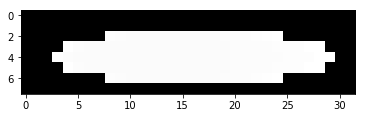

In [107]:
pylab.imshow(img, cmap='gray')

In [60]:
pylist = []

In [61]:
for root, dirs, files in os.walk('.\\cphcttoolbox-1.1.3'):
    for fn in files:
        if fn.endswith(".py"):
            pylist.append(os.path.join(root,fn))

In [62]:
import subprocess

In [65]:
for fn in pylist:
    subprocess.run(["python-modernize", "-w", fn])

In [169]:
import astra

In [ ]:
proj_geom

In [188]:
proj_data.shape

(512, 512, 308)

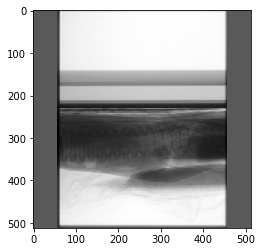

In [196]:
pylab.imshow(canon_img[:,:,20])

In [ ]:
vol_geom = astra.create_vol_geom(128, 128, 128)

angles = np.linspace(0, np.pi, 180,False)
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, 128, 192, angles)

proj_id, proj_data = astra.create_sino3d_gpu(cube, proj_geom, vol_geom)

In [208]:
proj_data.shape

(128, 180, 192)

In [358]:
canon_img = np.transpose(canon_img, (1,2,0))

In [ ]:
vol_geom = astra.create_vol_geom(128, 128, 128)
angles = np.linspace(0, np.pi, 180,False)
proj_geom = astra.create_proj_geom('parallel3d', 1.0, 1.0, 128, 192, angles)
cube = np.zeros((128,128,128))
cube[17:113,17:113,17:113] = 1
cube[17:97,33:97,50:105] = 0
proj_id, proj_data = astra.create_sino3d_gpu(cube, proj_geom, vol_geom)
pylab.gray()
pylab.figure(1)
pylab.imshow(proj_data[:,20,:])
rec_id = astra.data3d.create('-vol', vol_geom)
cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 150)

# Get the result
rec = astra.data3d.get(rec_id)
pylab.figure(2)
pylab.imshow(rec[:,:,65])
pylab.show()

astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)

In [313]:
recon_img.shape

(512, 1, 512)

In [373]:
canon_img_unscaled = copy.deepcopy(canon_img)

In [374]:
canon_img = (canon_img - np.amin(canon_img)) / (np.amax(canon_img) - np.amin(canon_img))

In [360]:
rec.shape

(512, 308, 512)

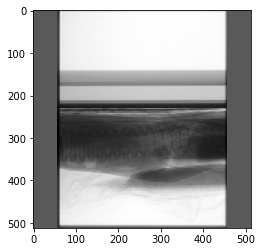

In [407]:
pylab.imshow(proj_data[:,20,:])

In [427]:
angles

array([-1.02381014])

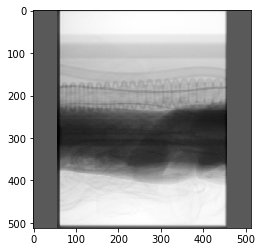

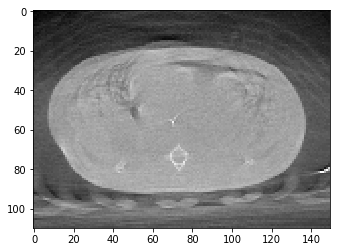

In [622]:
frames = canon_img.shape[1]
off = 0
vol_geom = astra.create_vol_geom((192, 192, 149)) #rows, colums, slices (y, x, z) 384, 384, 297

angles = np.array([(angle1 - theta)/180*np.pi for theta in angle1_increment[off:off+frames]])
#angles2 = [angle2 + theta for theta in angle2_increment[:frames]]
#angles = np.stack([angles1, angles2])
proj_geom = astra.create_proj_geom('cone', float(pixel_spacing[0]), float(pixel_spacing[1]),
                                   rows, cols, angles, d_patient/1, (d_detector-d_patient)/1)

# Display a single projection image
pylab.gray()
pylab.figure(1)
pylab.imshow(proj_data[:,off,:])

# Create a data object for the reconstruction
rec_id = astra.data3d.create('-vol', vol_geom)
#proj_id = astra.data3d.create('-sino', proj_geom, canon_img[:,:frames,:])
proj_id = astra.data3d.create('-proj3d', proj_geom, canon_img[:,off:off+frames,:]) #Coordinate order: row (v), angle, column (u)

# Set up the parameters for a reconstruction algorithm using the GPU
cfg = astra.astra_dict('FDK_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id

# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 150 iterations of the algorithm
# Note that this requires about 750MB of GPU memory, and has a runtime
# in the order of 10 seconds.
astra.algorithm.run(alg_id, 3)

# Get the result
rec = astra.data3d.get(rec_id) * -1
pylab.figure(2)
pylab.imshow(rec[50,10:120,20:170])#, vmin=.0010, vmax=0.0035)
pylab.show()

# Clean up. Note that GPU memory is tied up in the algorithm object,
# and main RAM in the data objects.
astra.algorithm.delete(alg_id)
astra.data3d.delete(rec_id)
astra.data3d.delete(proj_id)

In [610]:
np.amin(rec[:,:,::-1][50,20:170,10:120])

-0.01225862

In [609]:
np.amax(rec[:,:,::-1][50,20:170,10:120])

0.0033239664

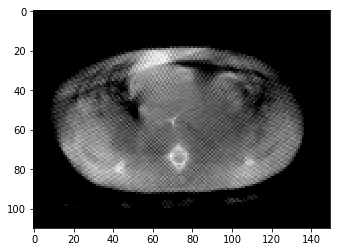

In [613]:
pylab.imshow(np.transpose(rec[:,:,::-1][50,20:170,10:120], (1,0)), vmin=0.0005)

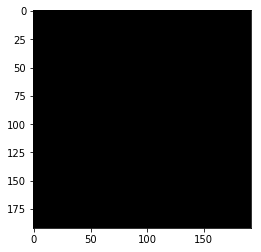

In [603]:
pylab.imshow(rec[50,:,:], vmin=0, vmax=200)

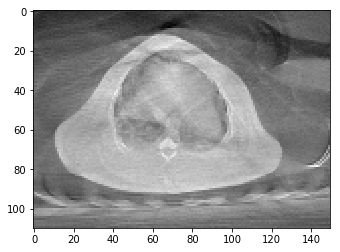

In [624]:
pylab.imshow(rec[100,10:120,20:170])#, vmin=0, vmax=200)

In [ ]:
pylab.imshow(rec[100,10:120,20:150], vmin=.0010, vmax=0.0035)

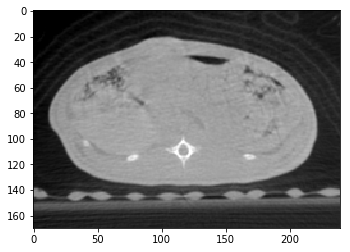

In [596]:
pylab.imshow(recon_img[180,320:150:-1,50:290], vmax=30000)

In [601]:
angle1

-104.58

In [564]:
from math import sin, cos

vectors = np.zeros((len(proj_geom['ProjectionAngles']), 12))
for i in range(len(proj_geom['ProjectionAngles'])):
    # source
    vectors[i,0] = sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginSource']
    vectors[i,1] = -cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginSource']
    vectors[i,2] = 0

    # center of detector
    vectors[i,3] = -sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginDetector']
    vectors[i,4] = cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DistanceOriginDetector']
    vectors[i,5] = 0

    # vector from detector pixel (0,0) to (0,1)
    vectors[i,6] = cos(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorSpacingX']
    vectors[i,7] = sin(proj_geom['ProjectionAngles'][i]) * proj_geom['DetectorSpacingX']
    vectors[i,8] = 0

    # vector from detector pixel (0,0) to (1,0)
    vectors[i,9] = 0
    vectors[i,10] = 0
    vectors[i,11] = proj_geom['DetectorSpacingY']

In [599]:
vectors[0,:]

array([ -7.83915651e+02,   2.03902554e+02,   0.00000000e+00,
         3.71634087e+02,  -9.66649147e+01,   0.00000000e+00,
        -1.86784809e-01,  -7.18105448e-01,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   7.42000000e-01])